## Goal of this Notebook
We want to look observe the conditional probability of a day's movement given the previous two days.

For three day momentum, we need lower resolution categories, so we will be using: big drop, small drop, small gain, and big gain. This way there are only 4 x 4 = 16 different two day prior trends to look at before we observe the conditional probability of the third day based on the previous two. 

In [1]:
from stock_utils import *

In [2]:
def categorize_movements(movements, n_cats=8):
	"""
	Given an array of movements, return an array of categories based on how relatively large the movements are.
	The default number of categories is 8.
	"""
	mu, sigma = np.mean(movements), np.std(movements)
	categories = []

	if (n_cats == 8):
		for i in range(len(movements)):
			if (movements[i] <= (mu - 2*sigma)):
				categories.append('vbd') ## very big drop
			elif (movements[i] <= (mu - sigma)):
				categories.append('bd')  ## big drop
			elif (movements[i] <= (mu - sigma/2)):
				categories.append('md')  ## medium drop
			elif (movements[i] < mu):
				categories.append('sd')  ## small drop
			elif (movements[i] >= (mu + 2*sigma)):
				categories.append('vbg') ## very big gain
			elif (movements[i] >= (mu + sigma)):
				categories.append('bg')  ## big gain
			elif (movements[i] >= (mu + sigma/2)):
				categories.append('mg')  ## medium gain
			elif (movements[i] >= mu):
				categories.append('sg')  ## small gain

	elif (n_cats == 4):
		for i in range(len(movements)):
			if (movements[i] <= (mu - sigma)):
				categories.append('bd')  ## big drop
			elif (movements[i] < mu):
				categories.append('sd')  ## small drop
			elif (movements[i] >= (mu + sigma)):
				categories.append('bg')  ## big gain
			elif (movements[i] >= mu):
				categories.append('sg')  ## small gain
	else:
		raise ValueError('Currently only 4 and 8 categories are supported')

	return categories

In [3]:
df = pd.DataFrame()
df = df.from_csv('stock_data/nvda.csv')
daily_movements = get_price_movement_percentages(df)

In [4]:
movement_categories = categorize_movements(daily_movements, n_cats=4)

In [5]:
bd_count = count_movement_category(movement_categories, 'bd')
sd_count = count_movement_category(movement_categories, 'sd')
sg_count = count_movement_category(movement_categories, 'sg')
bg_count = count_movement_category(movement_categories, 'bg')

total_cat_count = len(movement_categories)

p_bd = bd_count / total_cat_count
p_sd = sd_count / total_cat_count
p_sg = sg_count / total_cat_count
p_bg = bg_count / total_cat_count

cat_counts = [bd_count, sd_count, sg_count, bg_count]
cat_probs = [p_bd, p_sd, p_sg, p_bg]

In [6]:
three_day_trends = get_trends(movement_categories, 3)

In [7]:
def count_trends(trends, trend_to_count):
    count = 0
    for i in range(len(trends)):
        if trends[i] == trend_to_count:
            count = count + 1
    return count

There should be len(categories) - 2 three day trends. Let's check, and look at the counts of different trends.

In [8]:
total = 0
all_categories = ['bd', 'sd', 'sg', 'bg']

for first_category in all_categories:
    for second_category in all_categories:
        for third_category in all_categories:
            trend_name = first_category + '_' + second_category + '_' + third_category
            three_day_trend_count = count_trends(three_day_trends, trend_name)

            print('The count for ' + trend_name + ' is: ' + str(three_day_trend_count))
            total += three_day_trend_count

print('The total is: ' + str(total))

The count for bd_bd_bd is: 9
The count for bd_bd_sd is: 12
The count for bd_bd_sg is: 17
The count for bd_bd_bg is: 10
The count for bd_sd_bd is: 18
The count for bd_sd_sd is: 27
The count for bd_sd_sg is: 31
The count for bd_sd_bg is: 11
The count for bd_sg_bd is: 13
The count for bd_sg_sd is: 35
The count for bd_sg_sg is: 25
The count for bd_sg_bg is: 14
The count for bd_bg_bd is: 12
The count for bd_bg_sd is: 13
The count for bd_bg_sg is: 8
The count for bd_bg_bg is: 9
The count for sd_bd_bd is: 15
The count for sd_bd_sd is: 28
The count for sd_bd_sg is: 32
The count for sd_bd_bg is: 13
The count for sd_sd_bd is: 29
The count for sd_sd_sd is: 174
The count for sd_sd_sg is: 161
The count for sd_sd_bg is: 39
The count for sd_sg_bd is: 30
The count for sd_sg_sd is: 206
The count for sd_sg_sg is: 160
The count for sd_sg_bg is: 25
The count for sd_bg_bd is: 10
The count for sd_bg_sd is: 35
The count for sd_bg_sg is: 43
The count for sd_bg_bg is: 9
The count for sg_bd_bd is: 18
The count 

## Two day trends and bar graphs

In [9]:
def plot_two_day_probability_bar_graph(previous_day, count, two_day_trends, cat_probs, n_cats=8, show_baseline=True):
	two_day_probs = []
	if (n_cats == 8):
		all_categories = ['vbd', 'bd', 'md', 'sd', 'sg', 'mg', 'bg', 'vbg']
	elif(n_cats == 4):
		all_categories = ['bd', 'sd', 'sg', 'bg']
	for next_day in all_categories:
		two_day_name = previous_day +'_' + next_day
		two_day_count = count_trends(two_day_trends, two_day_name)
		two_day_prob = two_day_count / count
		two_day_probs.append(two_day_prob)

	plt.figure(figsize=(11,4))
	if (n_cats == 8):
		categories = ('Very Big Drop', 'Big Drop', 'Medium Drop', 'Small Drop', 'Small Gain', 'Medium Gain', 'Big Gain', 'Very Big Gain')
		ind = np.arange(8)
	elif (n_cats == 4):
		categories = ('Big Drop', 'Small Drop', 'Small Gain', 'Big Gain')
		ind = np.arange(4)
	width = 0.25

	if (show_baseline):
		orig_pl = plt.bar(ind+width, cat_probs, width, color='b', label='Original')
	conditioned_pl = plt.bar(ind, two_day_probs, width, color='r', label='After a ' + category_full_names[previous_day])

	plt.text(0.5, max(two_day_probs) * .95, 'n = ' + '{0:d}'.format(count), ha='center', va='center', weight='medium')

	plt.ylabel('Probabilities')
	plt.title('Probabilities of each Category')
	plt.xticks(ind+width, categories)
	plt.legend()
	#plt.show()

In [10]:
two_day_trends = get_trends(movement_categories, 2)
two_day_trends[1:10]

['bd_bg',
 'bg_sd',
 'sd_bg',
 'bg_sg',
 'sg_sd',
 'sd_sg',
 'sg_bd',
 'bd_sg',
 'sg_sg']

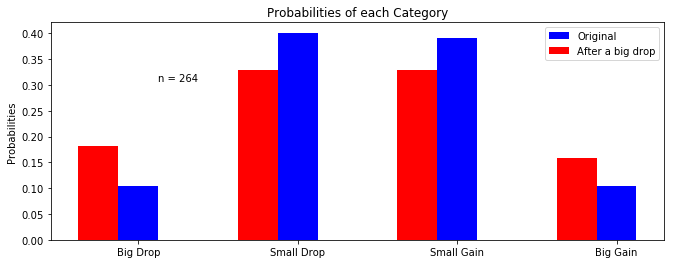

In [11]:
plot_two_day_probability_bar_graph('bd', bd_count, two_day_trends, cat_probs, n_cats=4)
plt.show()

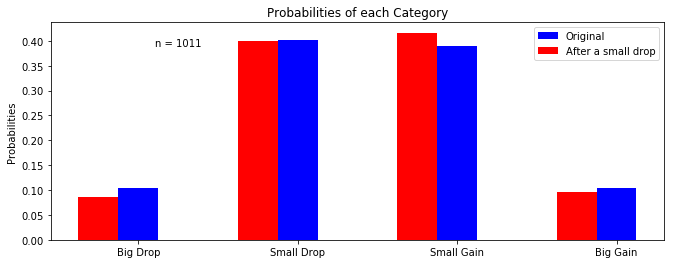

In [12]:
plot_two_day_probability_bar_graph('sd', sd_count, two_day_trends, cat_probs, n_cats=4)
plt.show()

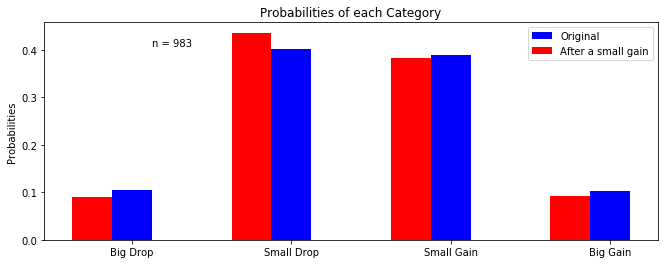

In [13]:
plot_two_day_probability_bar_graph('sg', sg_count, two_day_trends, cat_probs, n_cats=4)
plt.show()

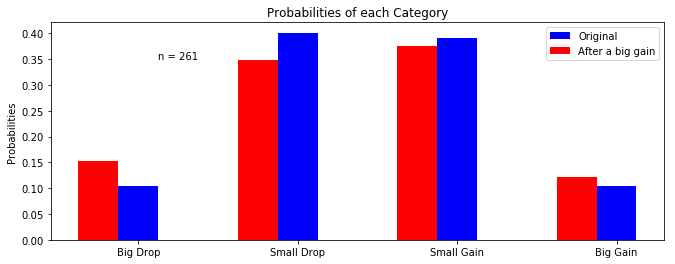

In [14]:
plot_two_day_probability_bar_graph('bg', bg_count, two_day_trends, cat_probs, n_cats=4)
plt.show()

In [15]:
def get_category_probabilities(movement_categories, n_categories=4):
    bd_count = count_movement_category(movement_categories, 'bd')
    sd_count = count_movement_category(movement_categories, 'sd')
    sg_count = count_movement_category(movement_categories, 'sg')
    bg_count = count_movement_category(movement_categories, 'bg')

    total_cat_count = len(movement_categories)

    p_bd = bd_count / total_cat_count
    p_sd = sd_count / total_cat_count
    p_sg = sg_count / total_cat_count
    p_bg = bg_count / total_cat_count

    category_counts = [bd_count, sd_count, sg_count, bg_count]
    category_probabilities = [p_bd, p_sd, p_sg, p_bg]
    
    return category_probabilities

## What is the utility in looking back the extra day?
For each two day category, plot the extra pervious day on the same bar graphs to visualize the difference.  
So we are comparing the effectiveness of looking at (x-2)(x-1)(x) vs (x-1)(x) for all (x-1) 

In [16]:
category_full_names = {'vbd':'very big drop', 'bd':'big drop', 'md':'medium drop', 'sd':'small drop',
                       'vbg':'very big gain', 'bg':'big gain', 'mg':'medium gain', 'sg':'small gain'}

In [17]:
def plot_three_day_probability_bar_graph(previous_day, two_day_trends, three_day_trends, movement_categories):
	"""
	Plot all of the following together on one figure: regular probabilities, probabilities conditioned on
	one event (the previous_day arg), and probabilities conditioned on two events (the previous_day, and all
	possible days before the previous_day)
	"""
	import matplotlib.patches as mpatches
	two_day_probs = []
	three_day_probs = []
	all_categories = ['bd', 'sd', 'sg', 'bg']
	cat_count = count_movement_category(movement_categories, previous_day)
	category_probabilities = get_category_probabilities(movement_categories)

    ## Get probabilities after 'previous_day'
	for next_day in all_categories:
		two_day_name = previous_day +'_' + next_day
		two_day_count = count_trends(two_day_trends, two_day_name)
		two_day_prob = two_day_count / cat_count
		two_day_probs.append(two_day_prob)
    
    ## Get probabilities after 'previous_day' and the day before
	for next_day in all_categories:
		for day_before_last in all_categories:  
			three_day_name = day_before_last +'_' + previous_day +'_' + next_day
			three_day_count = count_trends(three_day_trends, three_day_name)

			two_day_name = day_before_last +'_' + previous_day
			############## TEMPORARY -- think of a more elegant solution
			three_day_total = 0
			for category in all_categories:
				three_day_total += count_trends(three_day_trends, two_day_name + '_' + category)

			three_day_prob = three_day_count / three_day_total
			three_day_probs.append(three_day_prob)
			#print('Number of times ' + three_day_name + ' appeared is: ' + str(three_day_count))

	fig = plt.figure(figsize=(11,4))
	ax = fig.add_axes([0.1, 0.1, 0.8, 0.9])
	categories = ('Big Drop', 'Small Drop', 'Small Gain', 'Big Gain')
	ind = np.arange(4)
	width = 0.1

    ## Plot three day probabilities
	for i in range(int(len(three_day_probs) / 4)):
		pl = ax.bar(ind[i] + 1 * width, three_day_probs[i * 4], width, color='red')
		pl = ax.bar(ind[i] + 2 * width, three_day_probs[i * 4 + 1], width, color='#c64b4b')
		pl = ax.bar(ind[i] + 3 * width, three_day_probs[i * 4 + 2], width, color='#58c959')
		pl = ax.bar(ind[i] + 4 * width, three_day_probs[i * 4 + 3], width, color='green')

    ## Plot two day probability 
	conditioned_pl = ax.bar(ind + (5 * width), two_day_probs, width * 1.5, color='blue')
	orig_pl = ax.bar(ind + (6.5 * width), category_probabilities, width * 1.5, color='black')
        
	labels = ['Original',
              'After a ' + category_full_names[previous_day], 
              'After a big drop, then a ' + category_full_names[previous_day],
              'After a small drop, then a ' + category_full_names[previous_day], 
              'After a small gain, then a ' + category_full_names[previous_day], 
              'After a big gain, then a ' + category_full_names[previous_day]]
	original_patch = mpatches.Patch(color='black')
	two_day_patch = mpatches.Patch(color='blue')
	bd_x_patch = mpatches.Patch(color='red')
	sd_x_patch = mpatches.Patch(color='#c64b4b')
	sg_x_patch = mpatches.Patch(color='#58c959')
	bg_x_patch = mpatches.Patch(color='green')
	fig.legend([original_patch, two_day_patch, bd_x_patch, sd_x_patch, sg_x_patch, bg_x_patch], labels, 'upper right')

	plt.ylabel('Probabilities')
	plt.title('Probabilities of each Category')
	plt.xticks(ind + 4.5 * width, categories)

### The skinny bars give the added context of looking an extra day back
#### The blue bar is the conditional probability of looking back one day. The black bar is the probability on any given day

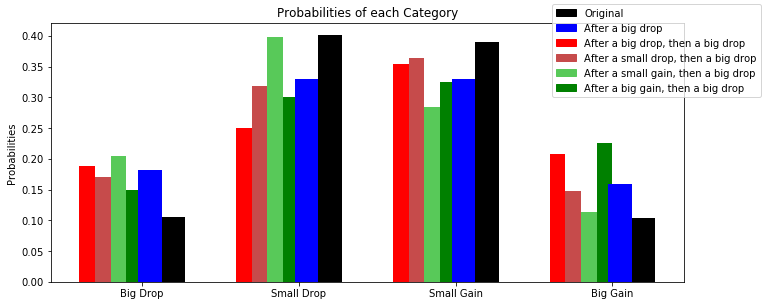

In [18]:
plot_three_day_probability_bar_graph('bd', two_day_trends, three_day_trends, movement_categories)
plt.show()

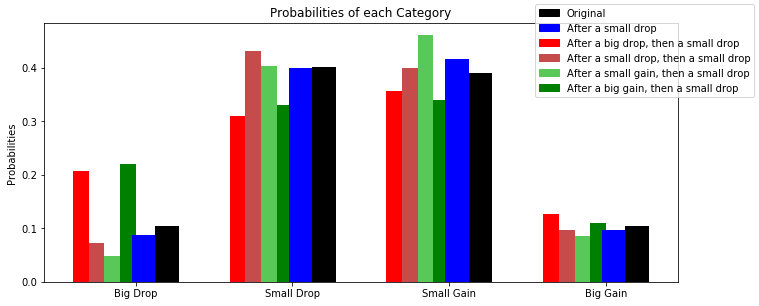

In [19]:
plot_three_day_probability_bar_graph('sd', two_day_trends, three_day_trends, movement_categories)
plt.show()

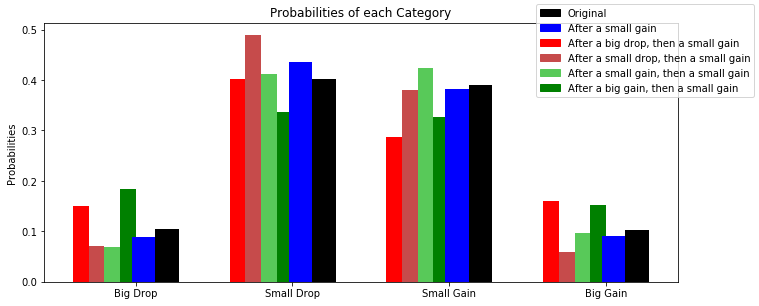

In [20]:
plot_three_day_probability_bar_graph('sg', two_day_trends, three_day_trends, movement_categories)
plt.show()

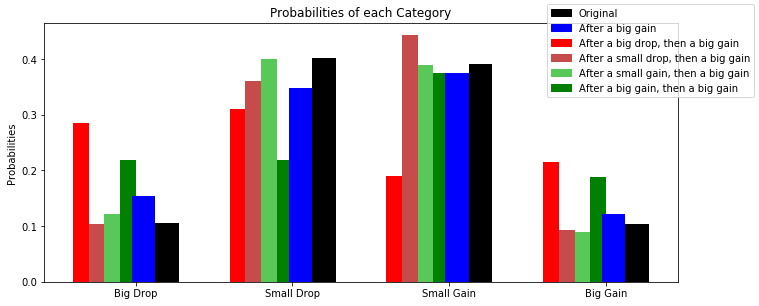

In [21]:
plot_three_day_probability_bar_graph('bg', two_day_trends, three_day_trends, movement_categories)
plt.show()

#### It looks like looking back an extra day is pretty informative! 
The probabilities sometimes shift even more than looking at just the previous day. Looking back that extra day seems to provide more context as to what's going on.

# SPY

In [22]:
df = pd.DataFrame()
df = df.from_csv('stock_data/amd.csv')
daily_movements = get_price_movement_percentages(df)

movement_categories = categorize_movements(daily_movements, n_cats=4)
category_probabilities = get_category_probabilities(movement_categories)

two_day_trends = get_trends(movement_categories, 2)
three_day_trends = get_trends(movement_categories, 3)

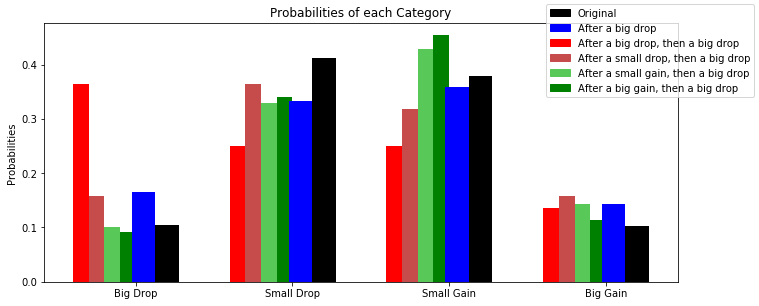

In [23]:
plot_three_day_probability_bar_graph('bd', two_day_trends, three_day_trends, movement_categories)
plt.show()

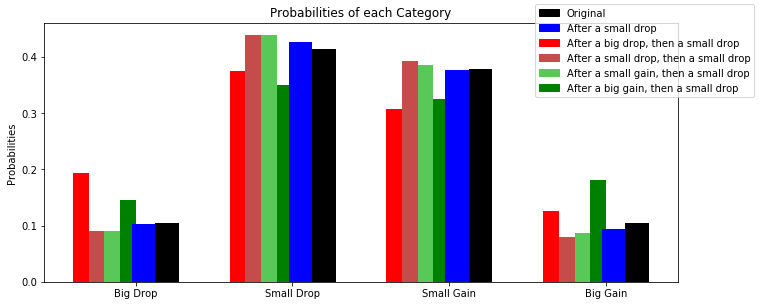

In [24]:
plot_three_day_probability_bar_graph('sd', two_day_trends, three_day_trends, movement_categories)
plt.show()

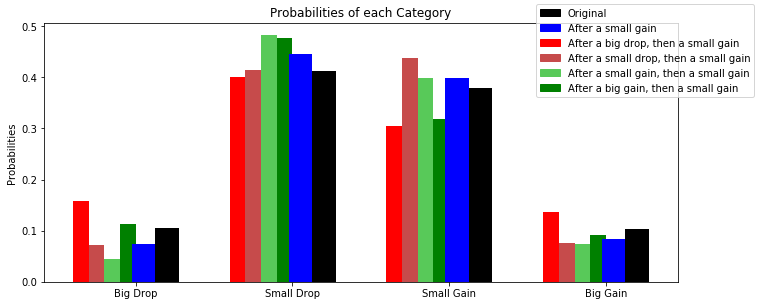

In [25]:
plot_three_day_probability_bar_graph('sg', two_day_trends, three_day_trends, movement_categories)
plt.show()

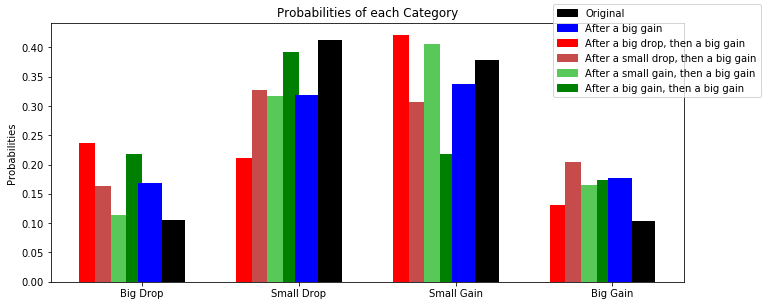

In [26]:
plot_three_day_probability_bar_graph('bg', two_day_trends, three_day_trends, movement_categories)
plt.show()

## All Stocks
#### Get the average behavior over all stocks

In [27]:
(all_two_day_trends, _, _, all_movement_categories) = get_trends_all_stocks(1, 2, ['bd', 'sd', 'sg', 'bd'], n_cats=4)

In [28]:
(all_three_day_trends, _, _, _) = get_trends_all_stocks(1, 3, ['bd', 'sd', 'sg', 'bd'], n_cats=4)

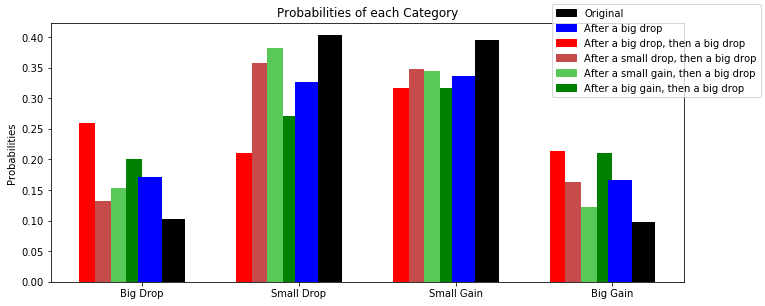

In [29]:
plot_three_day_probability_bar_graph('bd', all_two_day_trends, all_three_day_trends, all_movement_categories)
plt.show()

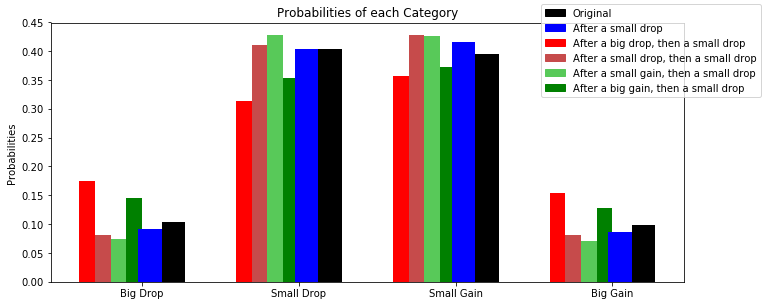

In [30]:
plot_three_day_probability_bar_graph('sd', all_two_day_trends, all_three_day_trends, all_movement_categories)
plt.show()

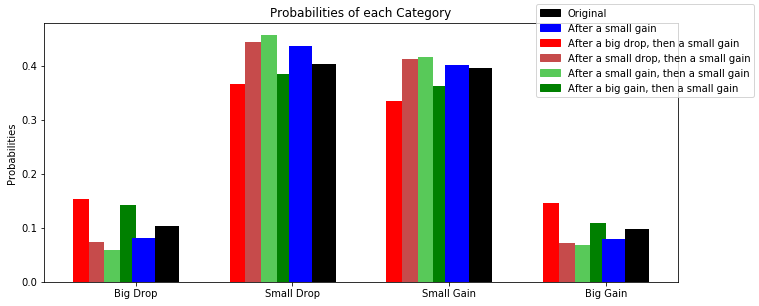

In [31]:
plot_three_day_probability_bar_graph('sg', all_two_day_trends, all_three_day_trends, all_movement_categories)
plt.show()

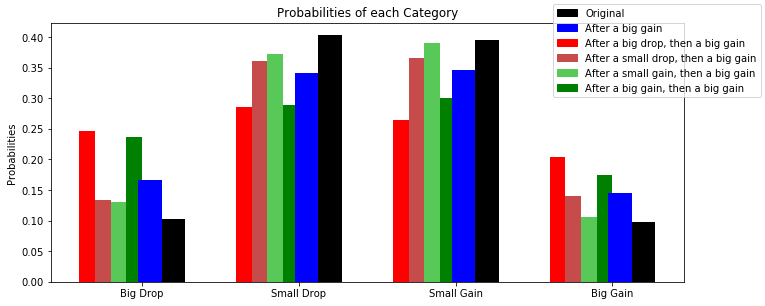

In [32]:
plot_three_day_probability_bar_graph('bg', all_two_day_trends, all_three_day_trends, all_movement_categories)
plt.show()

When we average over all stocks, it seems that behavior is more stable over the three day distribution, but they are still different enough to maybe be taken advantage of. For example, big drop -> big gain is skewed in favor of a drop.

Also, two small gains are more likely to result in a small drop.